# Geometric shape dataset generator

This notebook generates a geometric shape dataset. It consists of circles with varying size and triangles with varying rotation and size.
Each item is a 64 by 64 pixel image, generated by applying a Gaussian blur to an image with 7 times higher resolution.

In [17]:
import io
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import cv2
from scipy.stats import norm
import pickle as pk
np.random.seed(0)

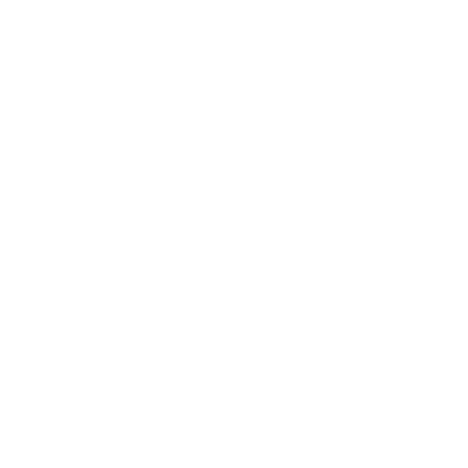

In [18]:
# Size of canvas
image_width = 64
image_height = 64
super_sampling_scale = 7
width = super_sampling_scale * image_width
height = super_sampling_scale * image_height

# Actual value of DPI does not matter for final output
# Larger value makes the matplotlib canvas smaller on screen
dpi = 100

# create a figure with fixed size
fig = plt.figure(frameon=False)
fig.set_size_inches(width/dpi, height/dpi)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.axis('off')
fig.add_axes(ax)

ax.set_xlim(0, width)
ax.set_ylim(0, height)
ax.patch.set_facecolor('blue')

io_buf = io.BytesIO()

In [19]:
def draw_shape(shape, x=.5*width, y=.5*height, bg_color=1, **kwargs):
    """
    Draw a shape on the matplotlib figure and return it as numpy array
    """
    # set background colour by adding a square patch
    bg_patch = ax.add_patch(patches.Rectangle((0, 0), width, height, color=str(bg_color)))
    if shape == 'circle':
        patch = generate_circle(x, y, **kwargs)
    elif shape == 'triangle':
        patch = generate_triangle(x, y, **kwargs)
    else:
        raise ValueError(f"Invalid shape: {shape}")
    # keep reference to the patch connected to the axis so it can be removed later
    patch = ax.add_patch(patch)
    # extract data from image
    # taken from https://stackoverflow.com/questions/7821518/matplotlib-save-plot-to-numpy-array
    io_buf.seek(0)
    fig.savefig(io_buf, format='rgba', dpi=dpi)
    io_buf.seek(0)
    # load (flattened) image into numpy array, reshape, keep only one channel (R)
    img = np.frombuffer(io_buf.getvalue(), dtype=np.uint8).reshape(width, height, -1)[..., 0]

    # remove the patches from the axis
    patch.remove()
    bg_patch.remove()
    return img

def generate_circle(x, y, radius, color):
    """
    Generate a matplotlib circle patch
    """
    return patches.Circle((x, y), radius, fc=str(color), ec=None)

def generate_triangle(x, y, radius, angle, color):
    """
    Generate a matplotlib triangle patch
    """
    a = rot(angle).dot(np.array([0, radius]))
    b = rot(120).dot(a)
    c = rot(120).dot(b)
    m = np.array([x,y])
    return patches.Polygon([a+m, b+m, c+m], fc=str(color), ec=None, closed=True)
    
def rot(angle_deg):
    """
    2D rotation matrix for given angle in degrees
    """
    angle = np.deg2rad(angle_deg)
    return np.array([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])

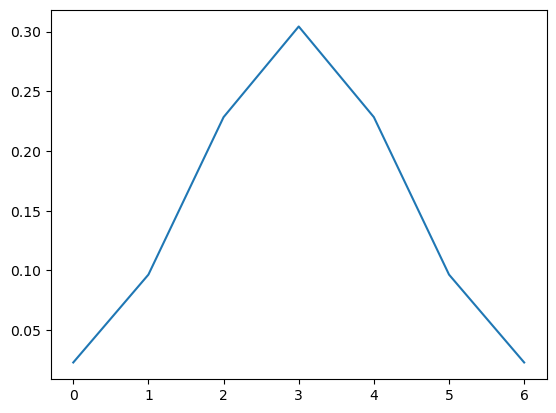

In [20]:
def get_smoothing_kernel(super_sampling_scale):
    """
    Gaussian smoothing kernel for given super-sampling scale
    """
    a = np.arange(super_sampling_scale).astype(float)
    a -= a.mean()
    a /= 0.66*a.std() 
    d = norm.pdf(a)
    d /= d.sum()
    return d

plt.plot(get_smoothing_kernel(7))

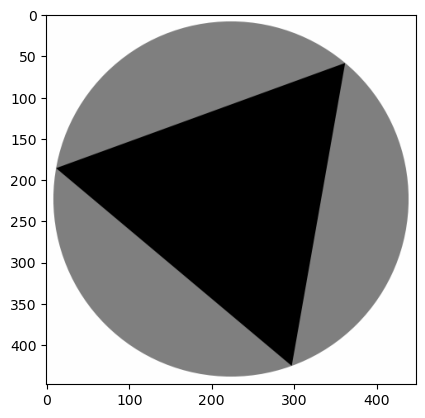

In [21]:
# Example triangle and circle at max radius
triangle = draw_shape('triangle', radius=.48*width, angle=40, color=.5)
circle = draw_shape('circle', radius=.48*width, color=.5)
data = circle + triangle

plt.figure()
plt.imshow(data, cmap='gray', vmin=0, vmax=255)

In [22]:
# Generate the circles and triangles
ncircle = 5000
ntriangle = 5000
shapes = np.empty(shape=(ncircle+ntriangle, height, width))

# circles
radii = np.random.uniform(.2*min(width, height), .48*min(width, height), ncircle)
colors = np.random.uniform(0, 1, ncircle)
bg_colors = np.random.uniform(0, 1, ncircle)
for n, radius in tqdm.tqdm(enumerate(radii)):
    shapes[n] = draw_shape('circle', radius=radius, color=colors[n], bg_color=bg_colors[n])

# triangles
radii = np.random.uniform(.2*min(width, height), .48*min(width, height), ntriangle)
angles = np.random.uniform(0, 360, ntriangle)
colors = np.random.uniform(0, 1, ntriangle)
bg_colors = np.random.uniform(0, 1, ntriangle)
for n, radius in tqdm.tqdm(enumerate(radii)):
    angle = angles[n]
    shapes[ncircle+n] = draw_shape('triangle', radius=radius, angle=angle, color=colors[n], bg_color=bg_colors[n])    

3487it [00:12, 285.80it/s]


KeyboardInterrupt: 

In [7]:
# scale to 0-1 (memory and compute intensive step)
shapes = shapes.astype(float) / 255.

10000it [02:24, 68.98it/s]


(10000, 448, 448)
(10000, 64, 64)


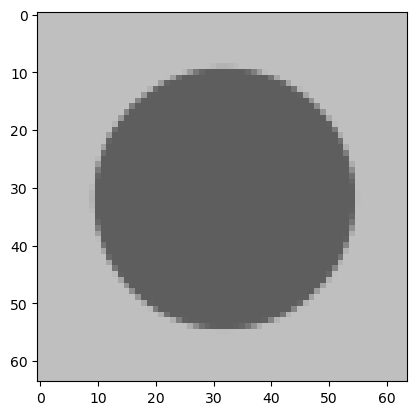

In [8]:
# apply Gaussian blur
for i,_ in tqdm.tqdm(enumerate(shapes)):
    shapes[i] = cv2.GaussianBlur(shapes[i], (super_sampling_scale, super_sampling_scale), 0.3*super_sampling_scale,0)

# Extract subset of smoothed data to obtain target image size
print(shapes.shape)
shapes = shapes[:,::super_sampling_scale,::super_sampling_scale] # NB! This causes the circle to shift by less than 1 pixel, but the result is not exactly centered.
print(shapes.shape)
plt.imshow(shapes[0], cmap='gray', vmin=0, vmax=1)

In [9]:
# Labels for each item in the dataset, circle=0, triangle=1
classes = ['circle', 'triangle']
labels = np.zeros(ncircle+ntriangle, dtype=int)
# circle=0, triangle=1
labels[ncircle:] = 1

In [10]:
from sklearn.model_selection import train_test_split

X = shapes
y = labels

np.random.seed(0)  # For reproducibility
train, test = train_test_split(range(len(y)), test_size=2500, shuffle=True, stratify=y)
X_train = X[train]
y_train = y[train]
X_test = X[test]
y_test = y[test]

np.savez_compressed('shapes.npz', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

In [11]:
!du -hs shapes.npz

 14M	shapes.npz


In [12]:
# load data from disk
fd = np.load('shapes.npz')
X = fd['X_train']
y = fd['y_train']
fd.close()

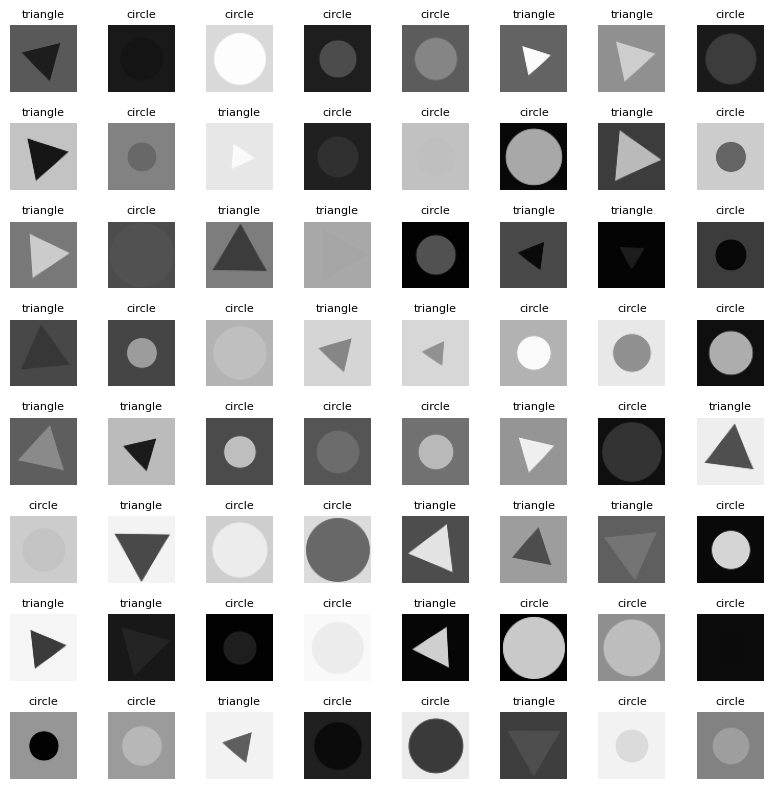

In [13]:
# Overview of the generated shapes
overview_fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(8, 8))
axes = axes.flatten()

for i in range(64):
    a = axes[i]
    a.imshow(X[i], cmap='gray', vmin=0, vmax=1)
    a.set_title(classes[y[i]], fontsize=8)
    a.axis('off')
    
overview_fig.tight_layout()

#### GENERATING NEW TEST DATASETS ####

#### GENERATING NEW TRIANGLES AND CIRCLES WITH DIFFERENT CONTRAST ####

In [96]:
# GENERATING NEW TRIANGLES AND CIRCLES WITH DIFFERENT CONTRAST

test_dataset_contrast = {"triangles": [], "circles": []}

image_width = 64
image_height = 64

colors = np.round(np.linspace(0, 1.00, 100), 2)

colors_dictionary = {'images': [], 'labels': [], 'roundedness': [], 'color': [], 'rotation': []}

for color in colors: 
    triangle = draw_shape('triangle', radius=.48*width, angle=0, color=color)
    triangle = cv2.resize(triangle, (64, 64))
    
    colors_dictionary['images'].append(triangle)
    colors_dictionary['labels'].append(1)
    colors_dictionary['roundedness'].append(-1)
    colors_dictionary['color'].append(color)
    colors_dictionary['rotation'].append(0)
    
for color in colors: 
    circle = draw_shape('circle', radius=.48*width, color=color)
    circle = cv2.resize(circle, (64, 64))
    
    colors_dictionary['images'].append(circle)
    colors_dictionary['labels'].append(0)
    colors_dictionary['roundedness'].append(-1)
    colors_dictionary['color'].append(color)
    colors_dictionary['rotation'].append(0)
    
colors_dictionary = {key: np.array(colors_dictionary[key]) for key in colors_dictionary.keys()}
np.savez('test_colors.npz', **colors_dictionary)

In [97]:
hey = np.load('test_colors.npz')

for i, label in enumerate(hey['labels']): 
    print(i, label)

0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
10 1
11 1
12 1
13 1
14 1
15 1
16 1
17 1
18 1
19 1
20 1
21 1
22 1
23 1
24 1
25 1
26 1
27 1
28 1
29 1
30 1
31 1
32 1
33 1
34 1
35 1
36 1
37 1
38 1
39 1
40 1
41 1
42 1
43 1
44 1
45 1
46 1
47 1
48 1
49 1
50 1
51 1
52 1
53 1
54 1
55 1
56 1
57 1
58 1
59 1
60 1
61 1
62 1
63 1
64 1
65 1
66 1
67 1
68 1
69 1
70 1
71 1
72 1
73 1
74 1
75 1
76 1
77 1
78 1
79 1
80 1
81 1
82 1
83 1
84 1
85 1
86 1
87 1
88 1
89 1
90 1
91 1
92 1
93 1
94 1
95 1
96 1
97 1
98 1
99 1
100 0
101 0
102 0
103 0
104 0
105 0
106 0
107 0
108 0
109 0
110 0
111 0
112 0
113 0
114 0
115 0
116 0
117 0
118 0
119 0
120 0
121 0
122 0
123 0
124 0
125 0
126 0
127 0
128 0
129 0
130 0
131 0
132 0
133 0
134 0
135 0
136 0
137 0
138 0
139 0
140 0
141 0
142 0
143 0
144 0
145 0
146 0
147 0
148 0
149 0
150 0
151 0
152 0
153 0
154 0
155 0
156 0
157 0
158 0
159 0
160 0
161 0
162 0
163 0
164 0
165 0
166 0
167 0
168 0
169 0
170 0
171 0
172 0
173 0
174 0
175 0
176 0
177 0
178 0
179 0
180 0
181 0
182 0
183 0
184 0


#### GENERATING NEW TRIANGLES WITH DIFFERENT ROTATIONS ####

In [78]:
angles = np.linspace(0, 360, 100)
print(len(angles))

angles_dictionary = {'images': [], 'labels': [], 'roundedness': [], 'color': [], 'rotation': []}

for angle in angles:
    triangle = draw_shape('triangle', radius=.48 * width, angle=angle, color=0)
    triangle = cv2.resize(triangle, (64, 64))
    
    angles_dictionary['images'].append(triangle)
    angles_dictionary['labels'].append(1)
    angles_dictionary['roundedness'].append(-1)
    angles_dictionary['color'].append(0)
    angles_dictionary['rotation'].append(angle)

angles_dictionary = {key: np.array(angles_dictionary[key]) for key in angles_dictionary.keys()}
np.savez('test_rotation.npz', **angles_dictionary)

100


/var/folders/2d/8lbwtrt52fqg4w50nnzq_t2c0000gn/T/ipykernel_54796/1433613298.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


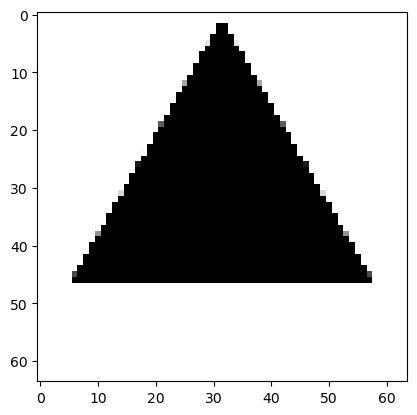

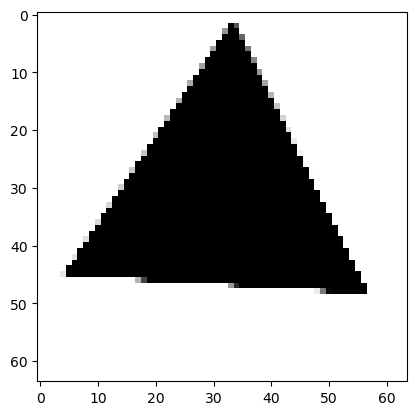

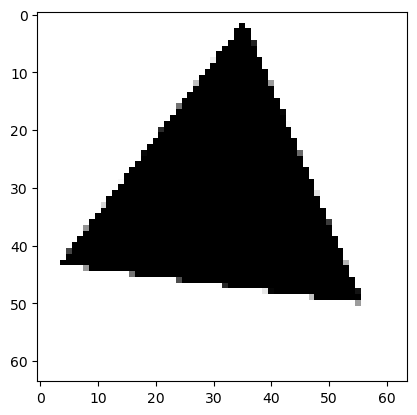

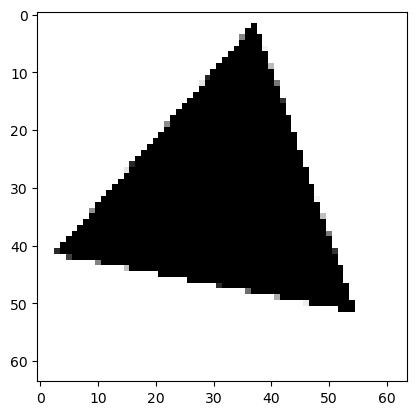

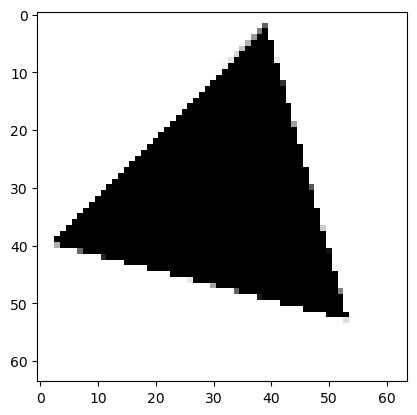

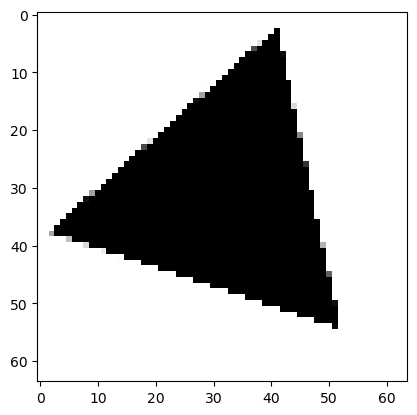

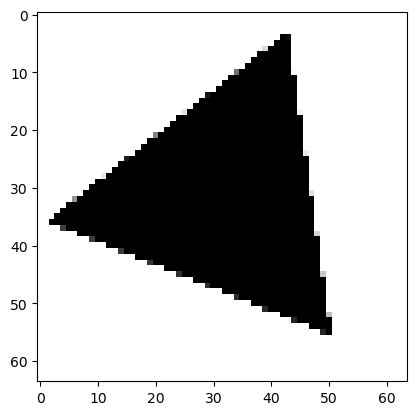

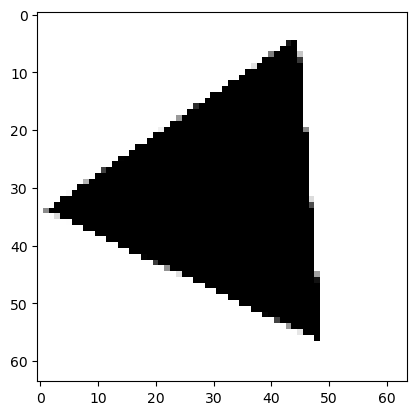

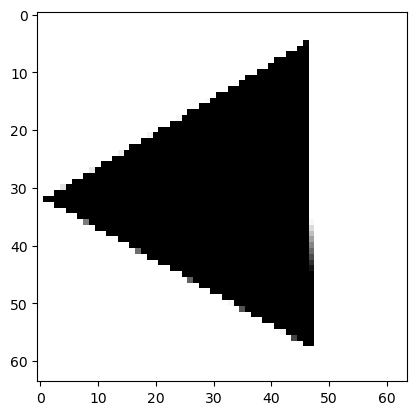

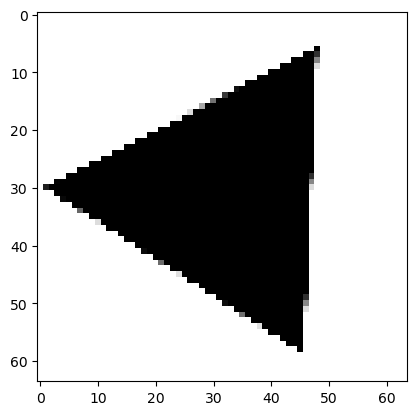

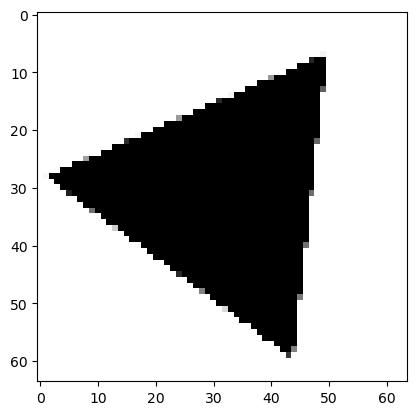

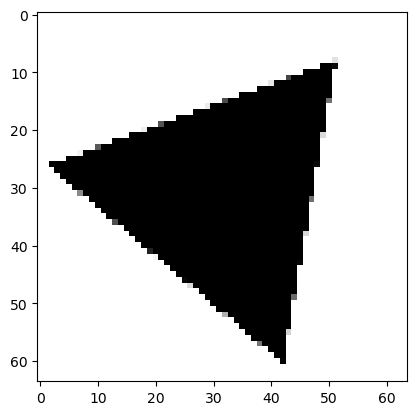

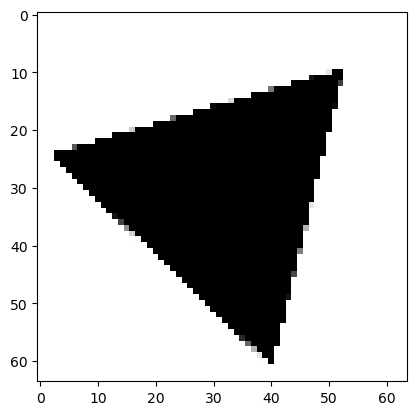

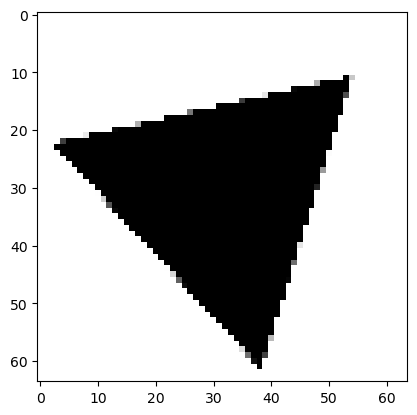

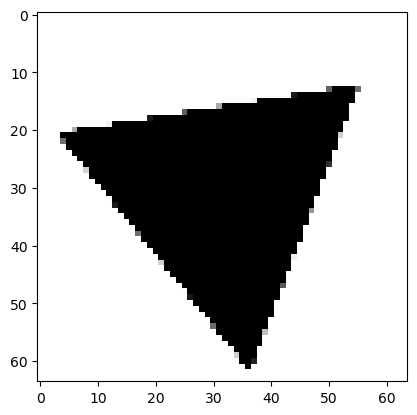

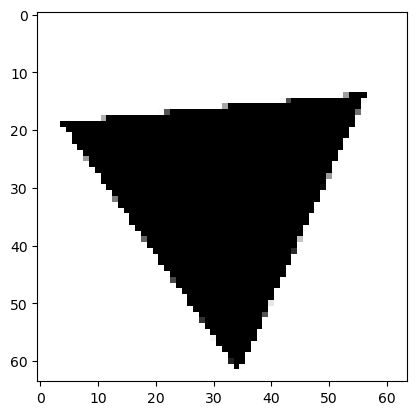

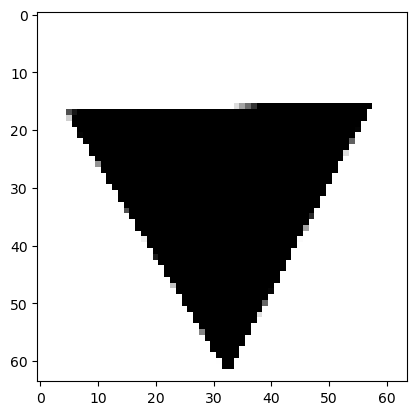

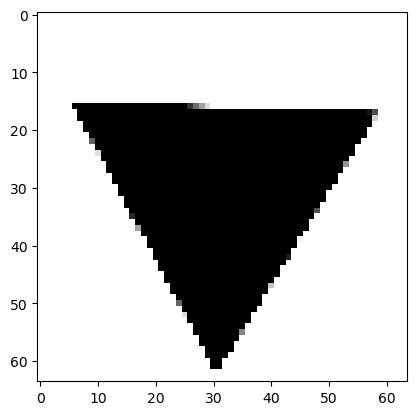

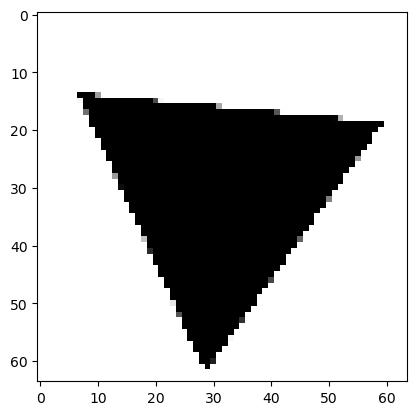

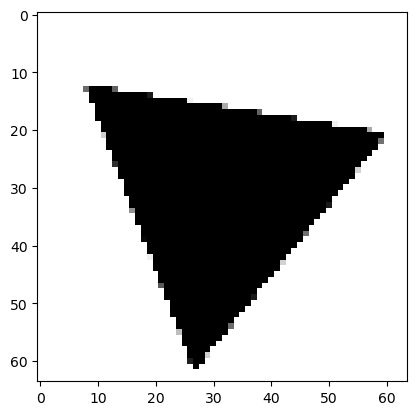

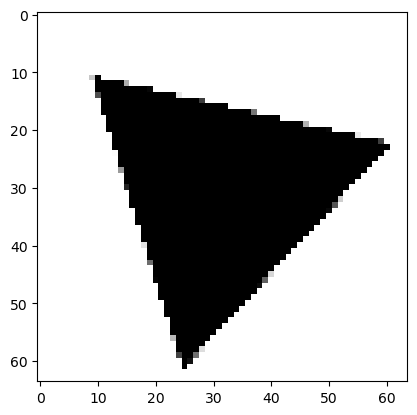

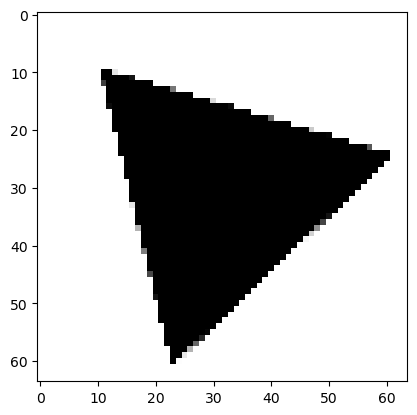

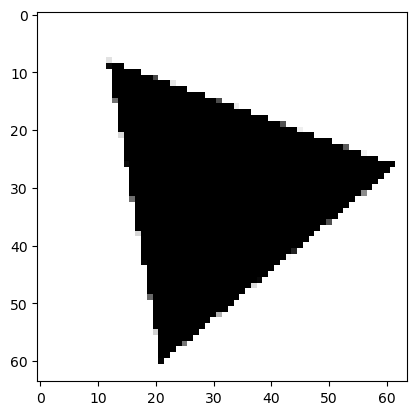

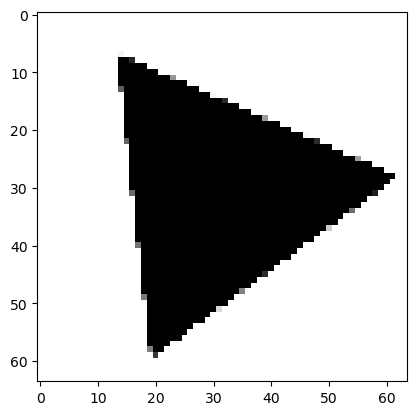

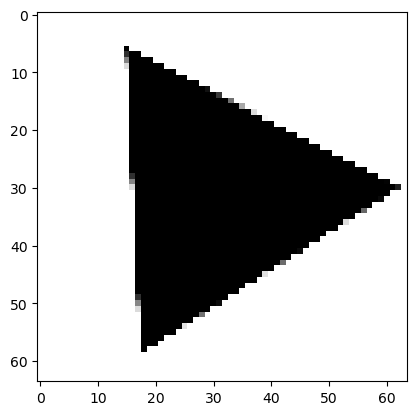

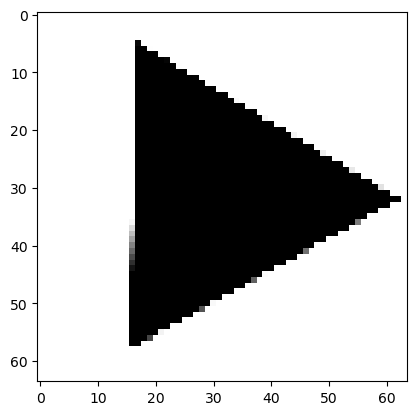

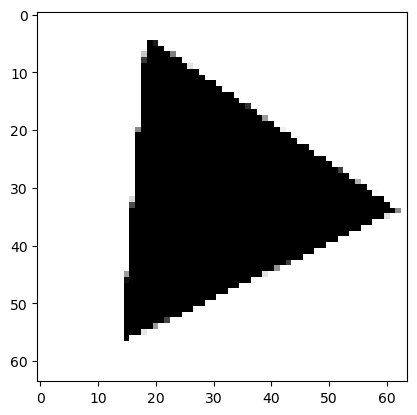

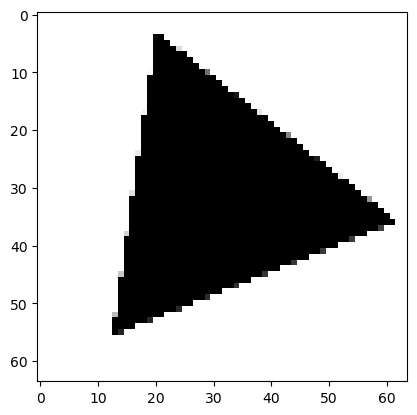

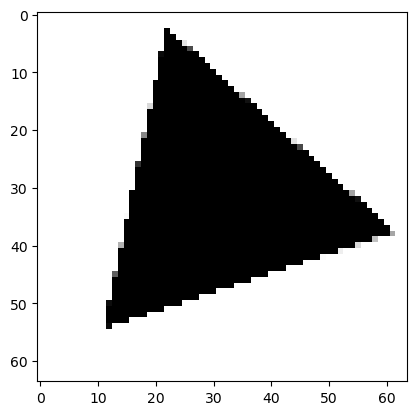

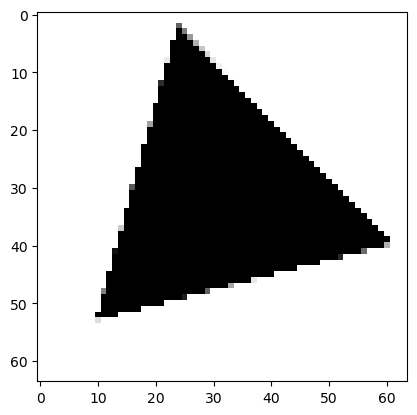

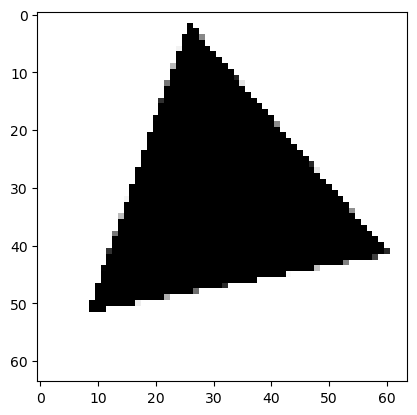

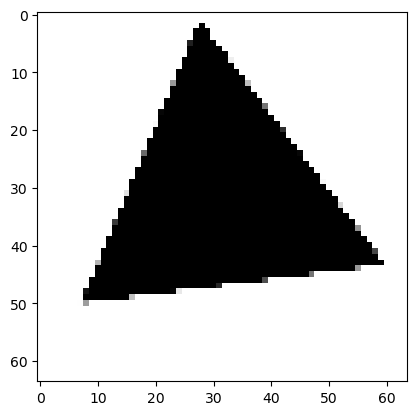

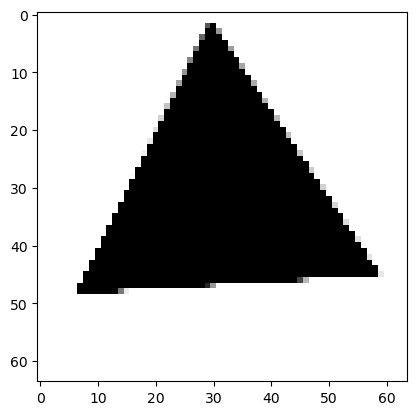

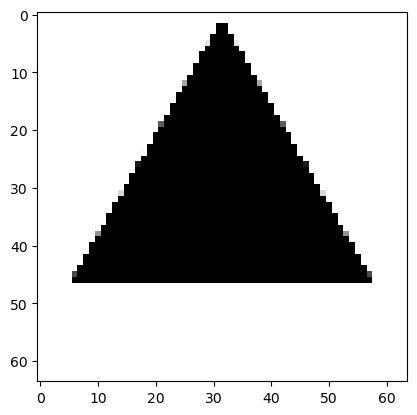

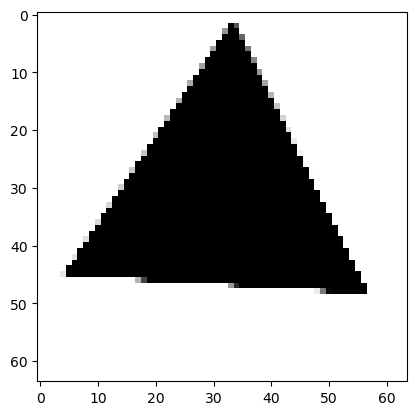

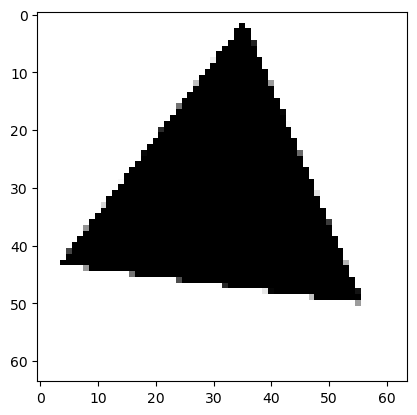

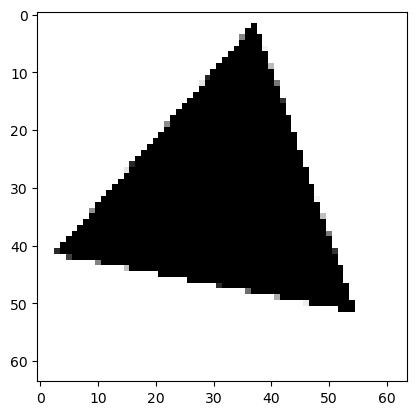

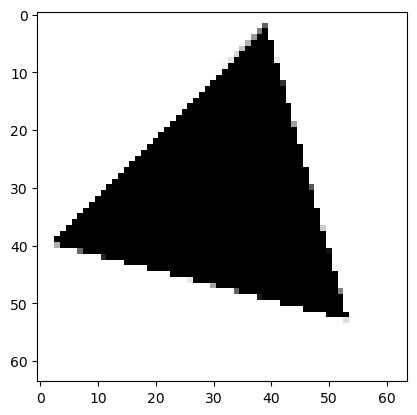

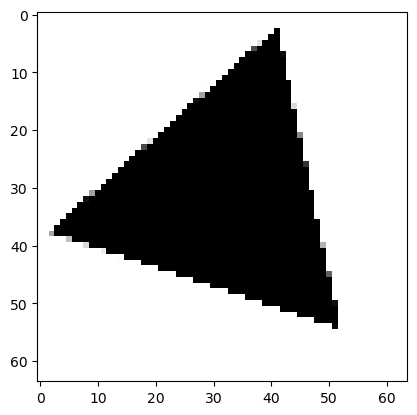

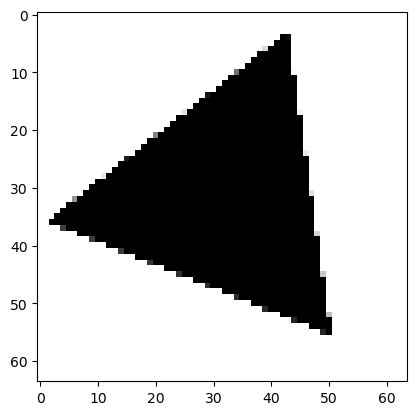

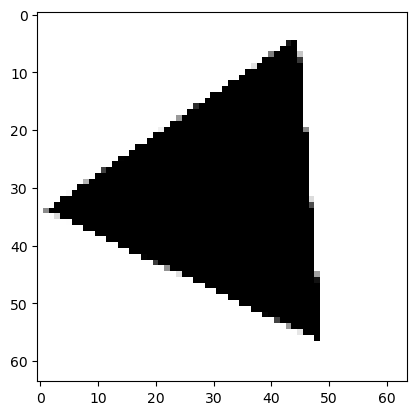

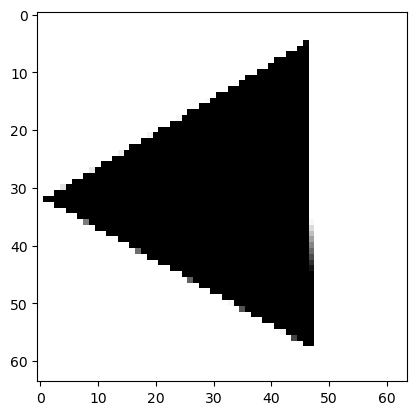

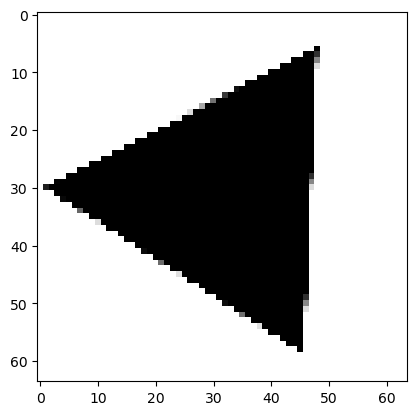

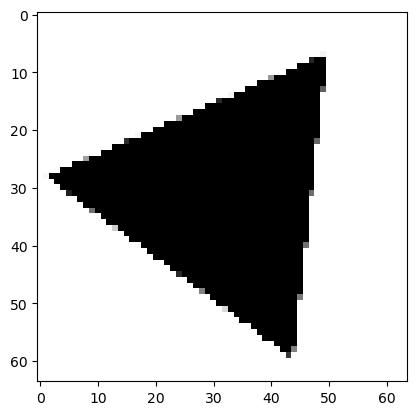

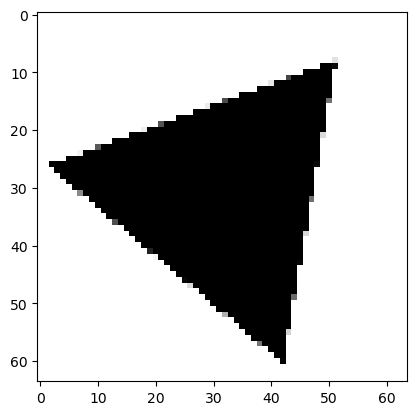

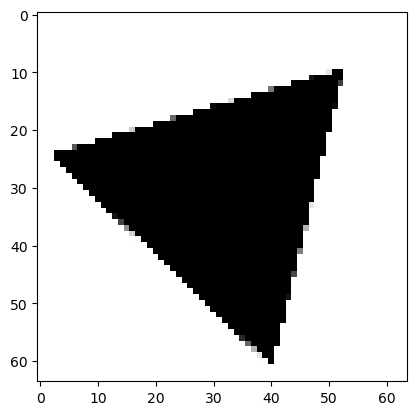

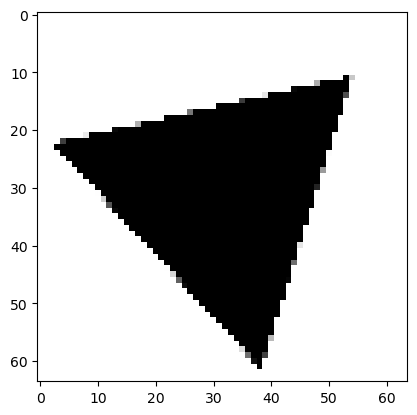

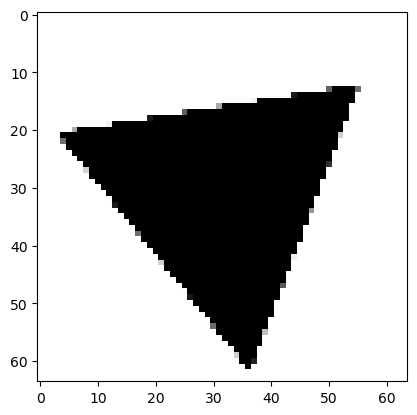

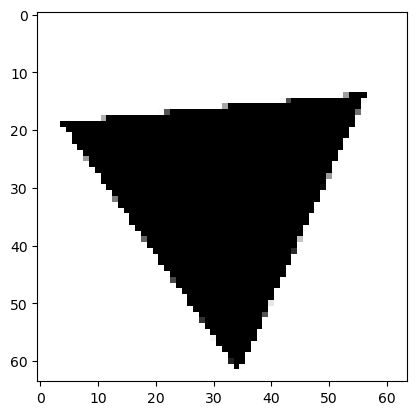

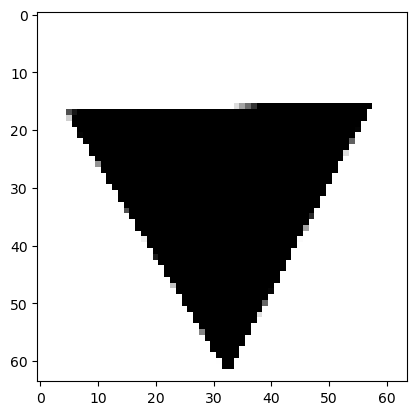

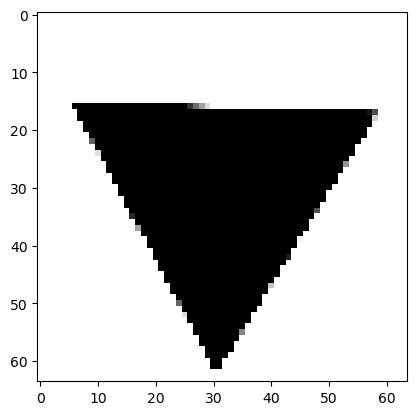

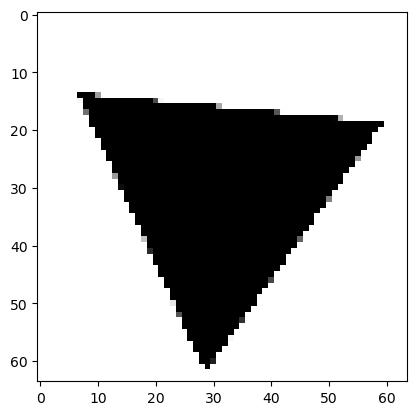

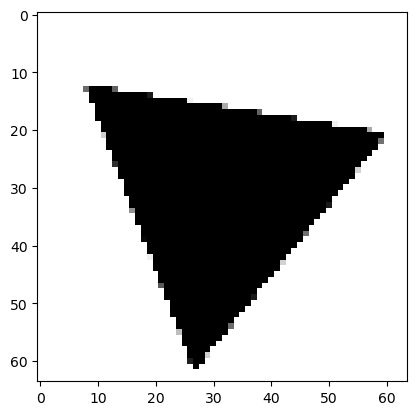

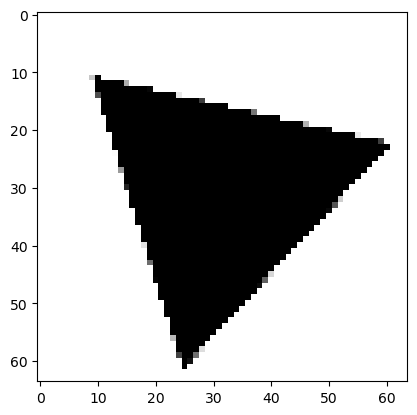

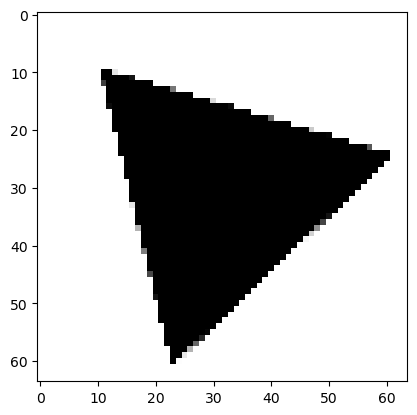

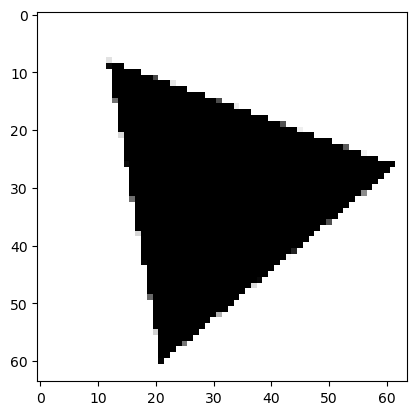

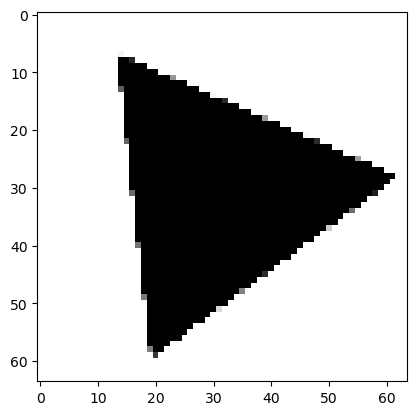

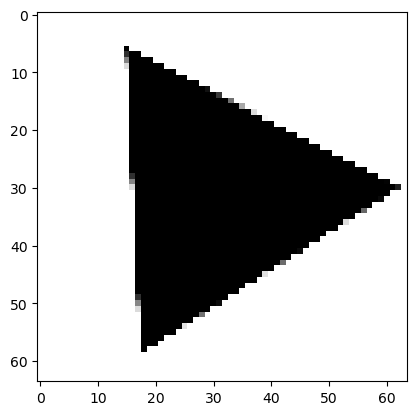

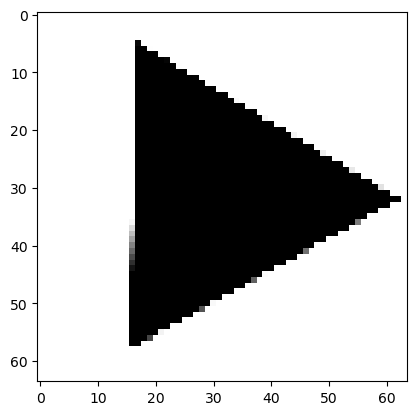

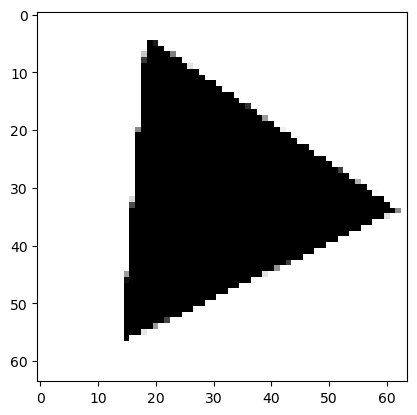

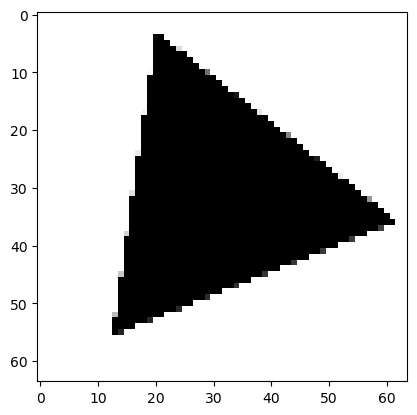

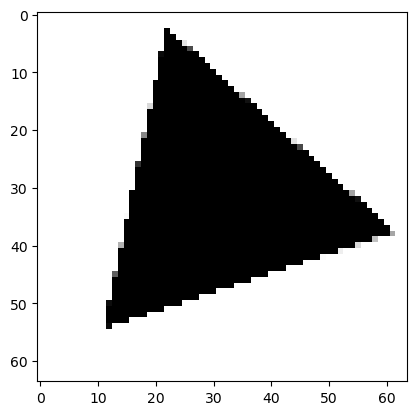

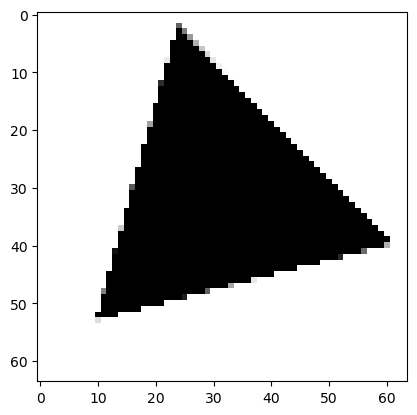

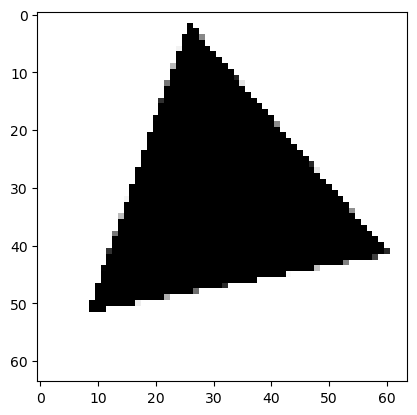

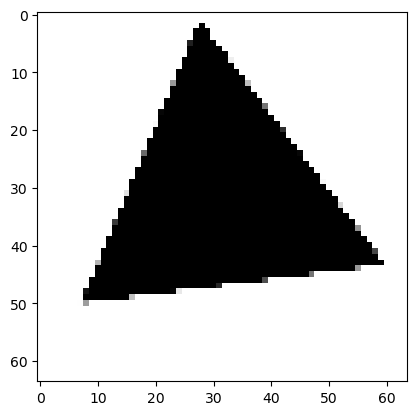

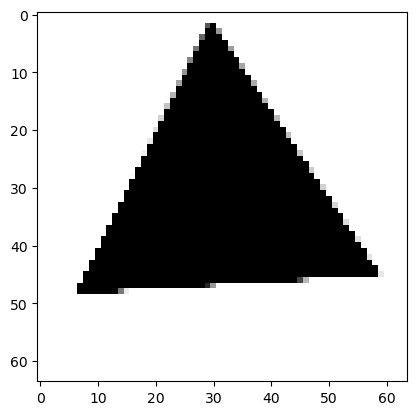

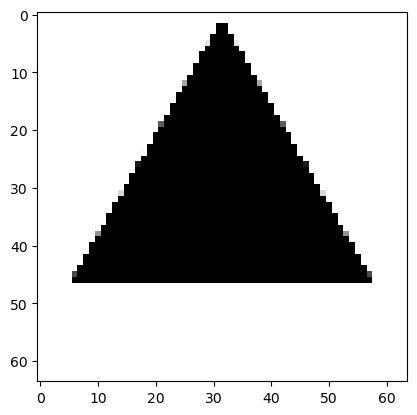

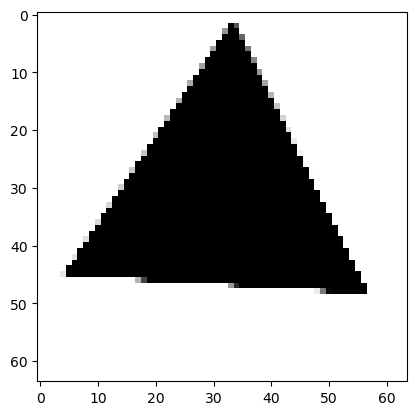

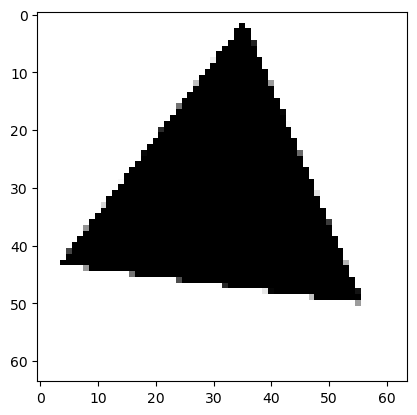

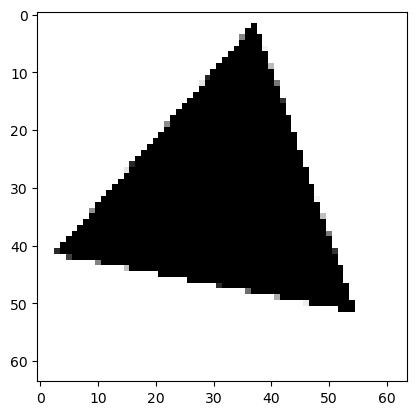

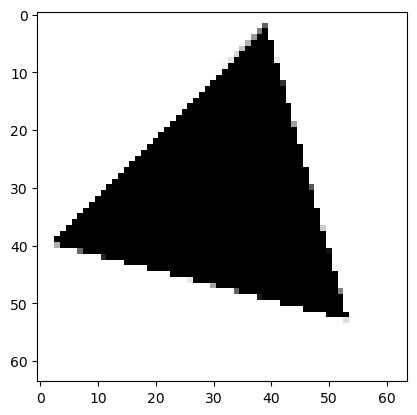

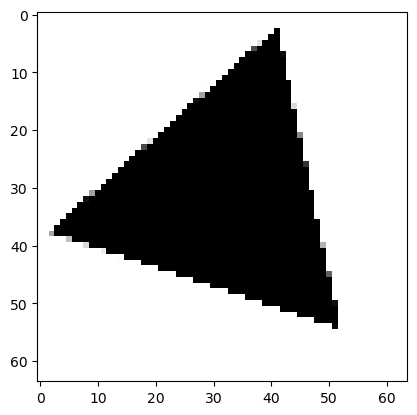

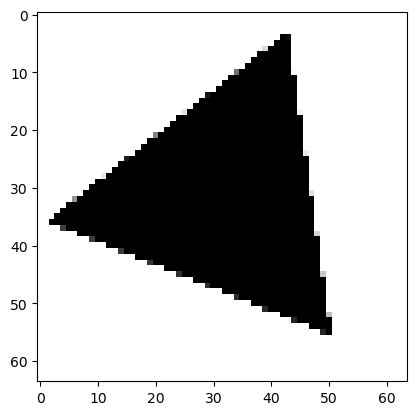

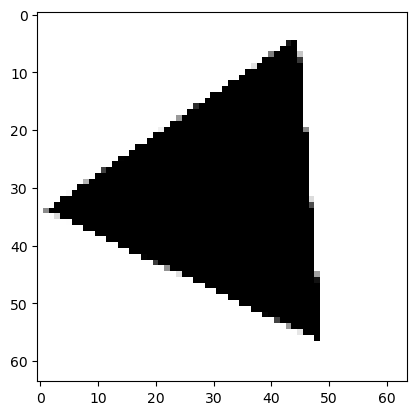

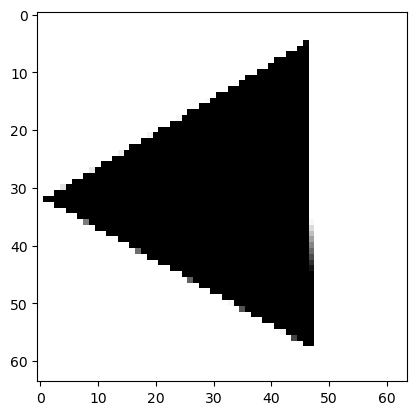

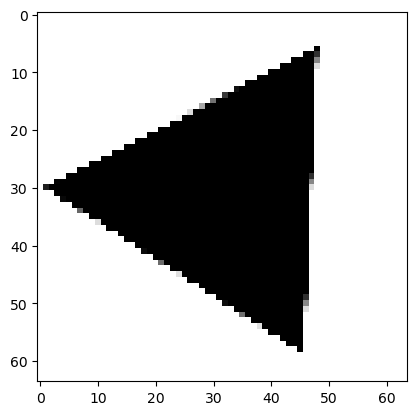

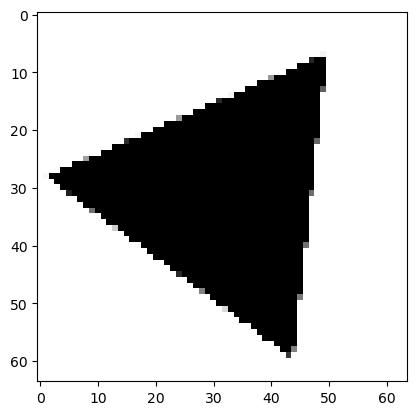

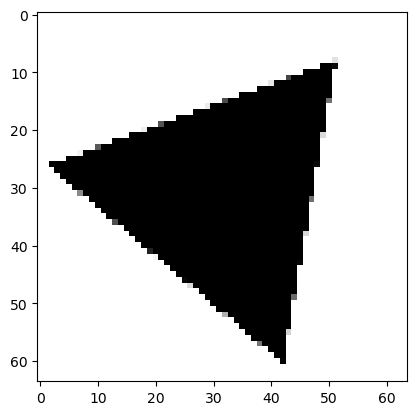

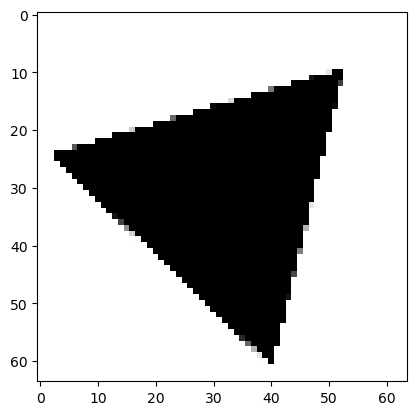

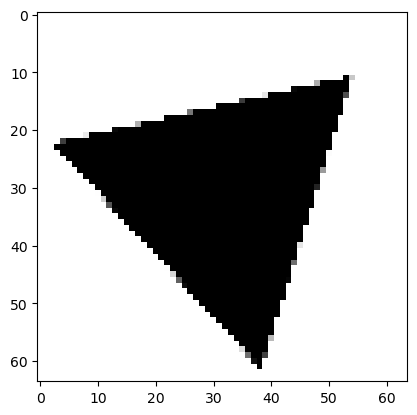

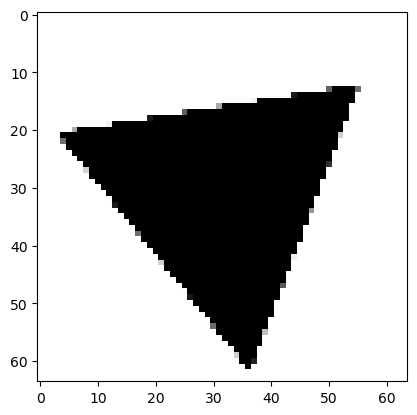

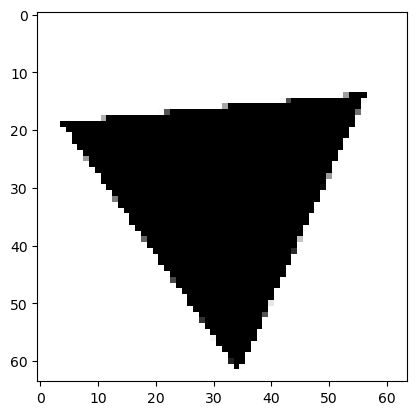

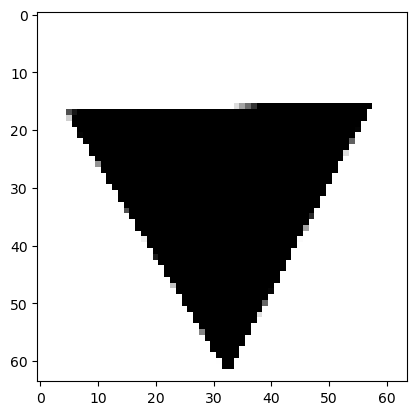

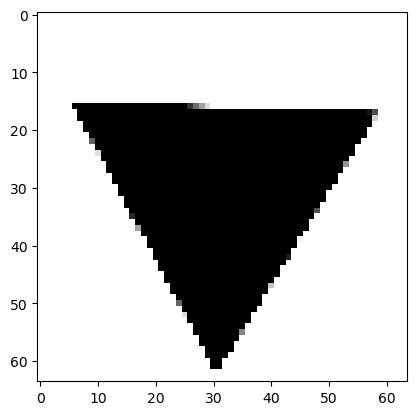

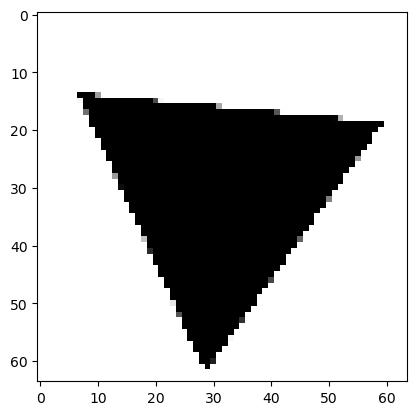

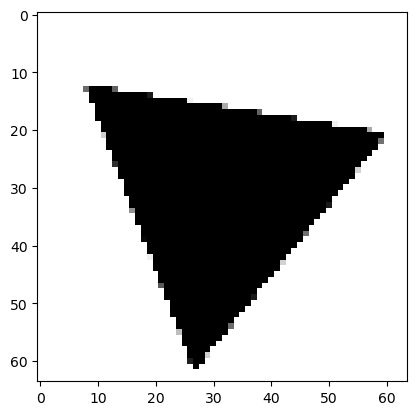

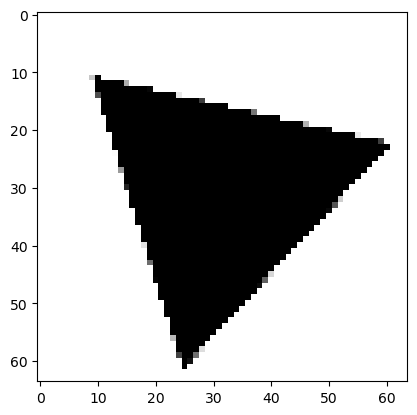

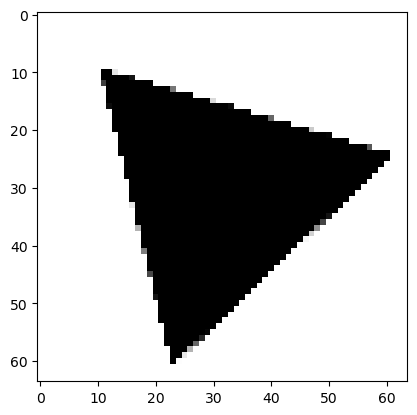

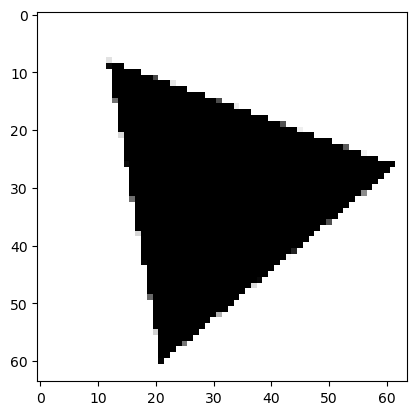

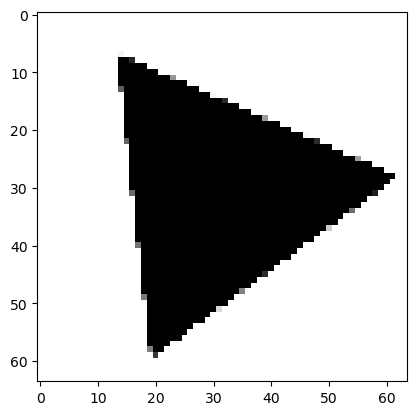

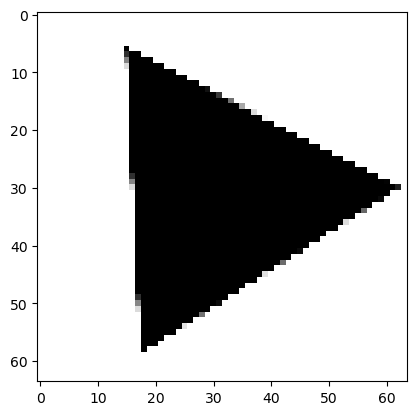

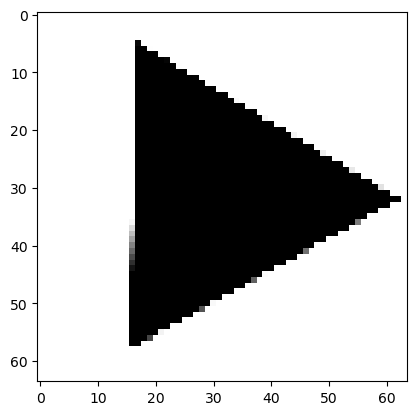

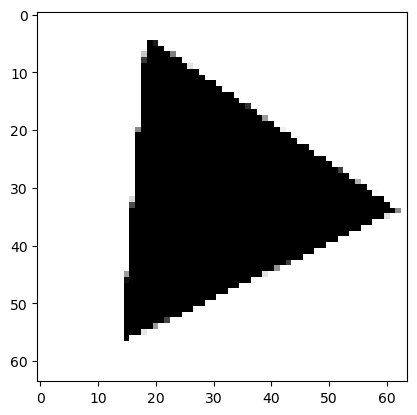

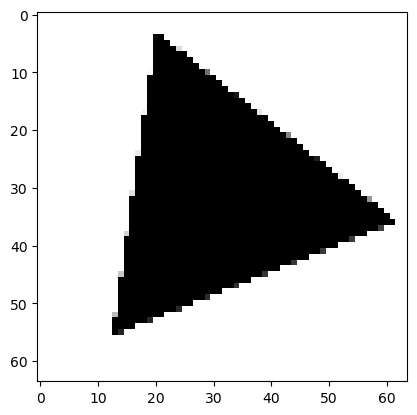

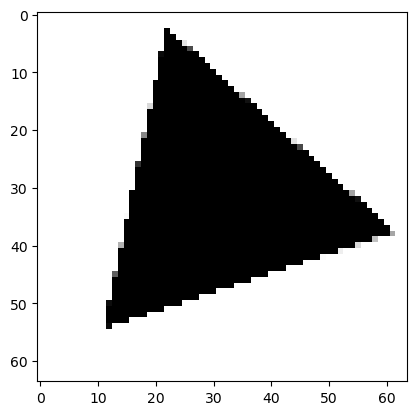

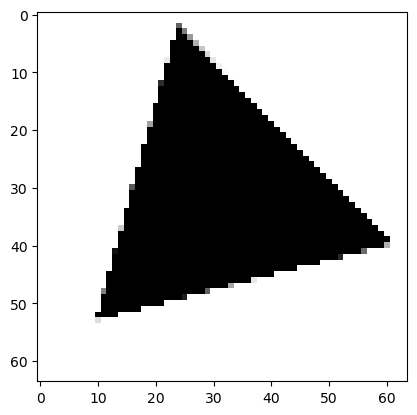

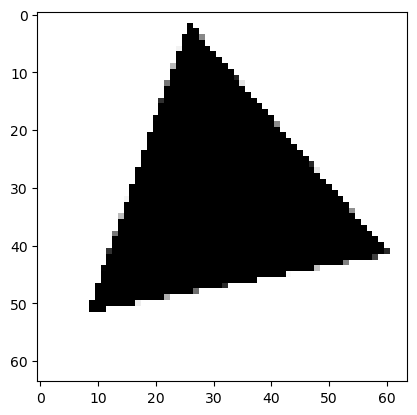

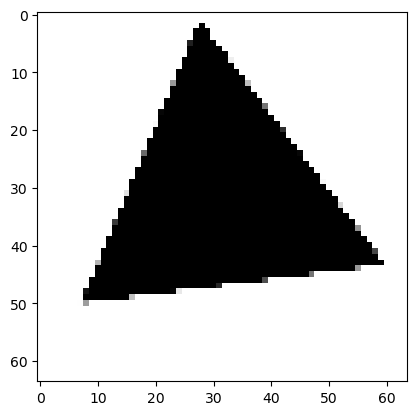

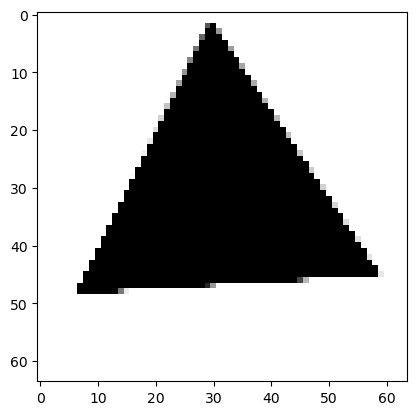

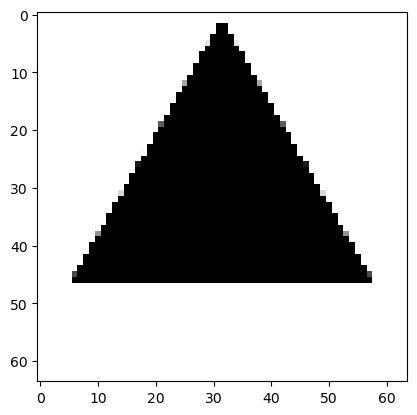

In [77]:
hey = np.load('test_rotation.npz')

for x in hey['images']: 
    plt.figure()
    plt.imshow(x, cmap='gray', vmin=0, vmax=255)